<a href="https://colab.research.google.com/github/Tobi-DataDetective/Energy_Load_Profile_Classification/blob/main/Time_series_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install download
!pip install optuna
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from IPython import display
import plotly as plotly
%matplotlib inline



import calendar
import datetime as dt
from datetime import timedelta, date
from pprint import pprint

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error


import joblib
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from scipy.stats import randint as sp_randint
from time import time
import pickle

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.8 MB/s eta 0:00:00


In [2]:
# importing libraries
import os
import pandas as pd
import numpy as np
import glob
import psycopg2
import sqlalchemy
import shutil
import glob
import warnings
from __future__ import absolute_import, division, print_function, unicode_literals
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

from datetime import datetime

import plotly.express as px


warnings.filterwarnings("ignore")

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from download import download

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

System_kW

In [4]:
df = pd.read_csv('df_for_ml.csv')
df['Time'] =  pd.to_datetime(df['Time'])
df.rename(columns={'load':'system_kW'}, inplace=True)
df

,Time,system_kW
0,2020-01-01 19:14:00,9.877
1,2020-01-01 19:15:00,9.821
2,2020-01-01 19:16:00,9.831
3,2020-01-01 19:17:00,9.810
4,2020-01-01 19:18:00,9.808
...,...,...
523535,2021-01-02 19:09:00,11.165
523536,2021-01-02 19:10:00,11.185
523537,2021-01-02 19:11:00,11.190
523538,2021-01-02 19:12:00,10.467


In [5]:
# data re-sampled based on an hour
df_by_hr_max = df.resample('H', on='Time').system_kW.max()

df_by_hr_max = pd.DataFrame(df_by_hr_max).reset_index()

df_by_hr_max.rename(columns = {'system_kW':'Max_Load'}, inplace = True)

import pandas as pd

# Get week number, with pd.DateOffset used to start the week on Sunday
week_date_values = df_by_hr_max["Time"].dt.isocalendar()
df_by_hr_max["week_date"] = (df_by_hr_max['Time'] - pd.to_timedelta(df_by_hr_max['Time'].dt.dayofweek, unit='d') + pd.DateOffset(days=-1)).dt.strftime("%Y-%m-%d")

# Combine with "(week n)" values
df_by_hr_max["week_date"] = df_by_hr_max["week_date"] + " " + "(week " + week_date_values["week"].astype(str) + ")"
df_by_hr_max

# data re-sampled based on an hour
df_by_hr_min = df.resample('H', on='Time').system_kW.min()

df_by_hr_min = pd.DataFrame(df_by_hr_min).reset_index()

df_by_hr_min.rename(columns = {'system_kW':'Min_Load'}, inplace = True)

import pandas as pd

# Get week number, with pd.DateOffset used to start the week on Sunday
week_date_values = df_by_hr_min["Time"].dt.isocalendar()
df_by_hr_min["week_date"] = (df_by_hr_min['Time'] - pd.to_timedelta(df_by_hr_min['Time'].dt.dayofweek, unit='d') + pd.DateOffset(days=-1)).dt.strftime("%Y-%m-%d")

# Combine with "(week n)" values
df_by_hr_min["week_date"] = df_by_hr_min["week_date"] + " " + "(week " + week_date_values["week"].astype(str) + ")"
Min_Load = df_by_hr_min.Min_Load.to_list()

# data re-sampled based on an hour
df_by_hr_mean = df.resample('H', on='Time').system_kW.mean()

df_by_hr_mean = pd.DataFrame(df_by_hr_mean).reset_index()

df_by_hr_mean.rename(columns = {'system_kW':'Mean_Load'}, inplace = True)

import pandas as pd

# Get week number, with pd.DateOffset used to start the week on Sunday
week_date_values = df_by_hr_mean["Time"].dt.isocalendar()
df_by_hr_mean["week_date"] = (df_by_hr_mean['Time'] - pd.to_timedelta(df_by_hr_mean['Time'].dt.dayofweek, unit='d') + pd.DateOffset(days=-1)).dt.strftime("%Y-%m-%d")

# Combine with "(week n)" values
df_by_hr_mean["week_date"] = df_by_hr_mean["week_date"] + " " + "(week " + week_date_values["week"].astype(str) + ")"
Mean_Load = df_by_hr_mean.Mean_Load.to_list()

df_max_min_mean = df_by_hr_max.assign(Min_Load=Min_Load,Mean_Load=Mean_Load)

df_hr_max_min_mean = df_max_min_mean[['Time','week_date','Max_Load','Min_Load','Mean_Load']]

df_hr_max_min_mean

,Time,week_date,Max_Load,Min_Load,Mean_Load
0,2020-01-01 19:00:00,2019-12-29 (week 1),9.930,9.808,9.855870
1,2020-01-01 20:00:00,2019-12-29 (week 1),9.870,9.727,9.803250
2,2020-01-01 21:00:00,2019-12-29 (week 1),11.638,9.728,11.166733
3,2020-01-01 22:00:00,2019-12-29 (week 1),11.503,11.320,11.400533
4,2020-01-01 23:00:00,2019-12-29 (week 1),11.419,8.853,10.381850
...,...,...,...,...,...
8804,2021-01-02 15:00:00,2020-12-27 (week 53),12.647,11.088,11.339983
8805,2021-01-02 16:00:00,2020-12-27 (week 53),14.608,9.756,11.961717
8806,2021-01-02 17:00:00,2020-12-27 (week 53),12.687,9.738,11.015783
8807,2021-01-02 18:00:00,2020-12-27 (week 53),11.176,9.504,10.625717


In [6]:
df_hr_max_min_mean["Month"] = df_hr_max_min_mean["Time"].dt.month
df_hr_max_min_mean

,Time,week_date,Max_Load,Min_Load,Mean_Load,Month
0,2020-01-01 19:00:00,2019-12-29 (week 1),9.930,9.808,9.855870,1
1,2020-01-01 20:00:00,2019-12-29 (week 1),9.870,9.727,9.803250,1
2,2020-01-01 21:00:00,2019-12-29 (week 1),11.638,9.728,11.166733,1
3,2020-01-01 22:00:00,2019-12-29 (week 1),11.503,11.320,11.400533,1
4,2020-01-01 23:00:00,2019-12-29 (week 1),11.419,8.853,10.381850,1
...,...,...,...,...,...,...
8804,2021-01-02 15:00:00,2020-12-27 (week 53),12.647,11.088,11.339983,1
8805,2021-01-02 16:00:00,2020-12-27 (week 53),14.608,9.756,11.961717,1
8806,2021-01-02 17:00:00,2020-12-27 (week 53),12.687,9.738,11.015783,1
8807,2021-01-02 18:00:00,2020-12-27 (week 53),11.176,9.504,10.625717,1


In [7]:
df.describe()

,system_kW
count,523540.000000
mean,16.214630
std,11.395524
min,0.965000
25%,8.721000
50%,10.263000
75%,22.562000
max,63.334000


In [8]:
df = df_hr_max_min_mean[['Time','Month','Mean_Load']]

In [9]:
df_non_index = df.copy()

In [10]:
df = df.set_index('Time')

In [11]:
df

,Month,Mean_Load
Time,,
2020-01-01 19:00:00,1,9.855870
2020-01-01 20:00:00,1,9.803250
2020-01-01 21:00:00,1,11.166733
2020-01-01 22:00:00,1,11.400533
2020-01-01 23:00:00,1,10.381850
...,...,...
2021-01-02 15:00:00,1,11.339983
2021-01-02 16:00:00,1,11.961717
2021-01-02 17:00:00,1,11.015783


In [12]:
df.loc['2020']

,Month,Mean_Load
Time,,
2020-01-01 19:00:00,1,9.855870
2020-01-01 20:00:00,1,9.803250
2020-01-01 21:00:00,1,11.166733
2020-01-01 22:00:00,1,11.400533
2020-01-01 23:00:00,1,10.381850
...,...,...
2020-12-31 19:00:00,12,10.489567
2020-12-31 20:00:00,12,10.448850
2020-12-31 21:00:00,12,10.464600


In [13]:
load_data = df['Mean_Load']
load_data

Time
2020-01-01 19:00:00     9.855870
2020-01-01 20:00:00     9.803250
2020-01-01 21:00:00    11.166733
2020-01-01 22:00:00    11.400533
2020-01-01 23:00:00    10.381850
                         ...    
2021-01-02 15:00:00    11.339983
2021-01-02 16:00:00    11.961717
2021-01-02 17:00:00    11.015783
2021-01-02 18:00:00    10.625717
2021-01-02 19:00:00    10.750500
Name: Mean_Load, Length: 8809, dtype: float64

<AxesSubplot:xlabel='Time'>

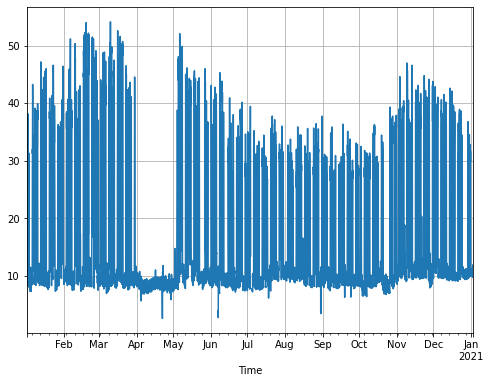

In [14]:
load_data.plot(grid=True)

<AxesSubplot:xlabel='Time'>

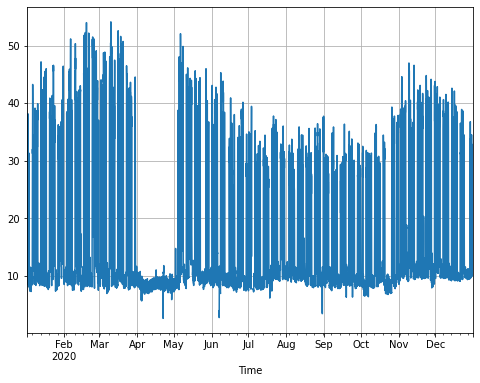

In [15]:
df_2020 = df['2020']
load_data_2020 = df_2020['Mean_Load']
load_data_2020.plot(grid=True)

In [16]:
df[df['Month']==3]

,Month,Mean_Load
Time,,
2020-03-01 00:00:00,3,10.203950
2020-03-01 01:00:00,3,10.158117
2020-03-01 02:00:00,3,9.927317
2020-03-01 03:00:00,3,9.868483
2020-03-01 04:00:00,3,9.766383
...,...,...
2020-03-31 19:00:00,3,9.284133
2020-03-31 20:00:00,3,9.271733
2020-03-31 21:00:00,3,8.959567


In [17]:
df

,Month,Mean_Load
Time,,
2020-01-01 19:00:00,1,9.855870
2020-01-01 20:00:00,1,9.803250
2020-01-01 21:00:00,1,11.166733
2020-01-01 22:00:00,1,11.400533
2020-01-01 23:00:00,1,10.381850
...,...,...
2021-01-02 15:00:00,1,11.339983
2021-01-02 16:00:00,1,11.961717
2021-01-02 17:00:00,1,11.015783


In [18]:
import plotly.express as px
fig = px.line(df_non_index, x='Time', y='Mean_Load', title = 'Time VS Load')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

Group by Months

In [19]:
df.groupby('Month').agg({'Mean_Load':['min','max']})

Mean_Load           
            min        max
Month                     
1      7.311267  47.193267
2      7.355867  54.007783
3      6.966267  54.140333
4      2.643167  11.809400
5      7.283567  52.082867
6      2.780400  45.321333
7      6.171933  39.462317
8      3.463867  37.757333
9      6.335067  36.377967
10     6.418800  39.340483
11     7.940367  46.998900
12     9.086217  42.885600

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

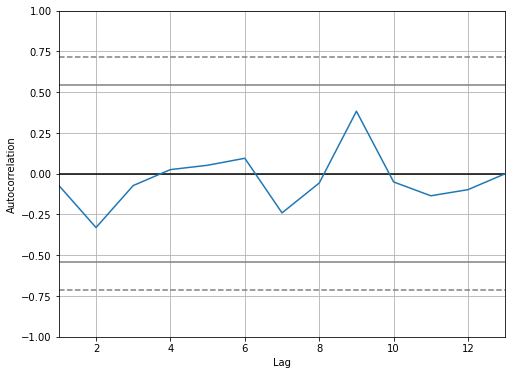

In [20]:
pd.plotting.autocorrelation_plot(df['Mean_Load'].resample("1m").mean())

In [21]:
df['Mean_Load'].resample("1m").mean()

Time
2020-01-31    18.336361
2020-02-29    19.910790
2020-03-31    19.491131
2020-04-30     8.254760
2020-05-31    15.798827
2020-06-30    16.248740
2020-07-31    16.019696
2020-08-31    16.076558
2020-09-30    15.289685
2020-10-31    13.992299
2020-11-30    18.737633
2020-12-31    17.112862
2021-01-31    10.540870
Freq: M, Name: Mean_Load, dtype: float64

Stationary Test

In [22]:
df

,Month,Mean_Load
Time,,
2020-01-01 19:00:00,1,9.855870
2020-01-01 20:00:00,1,9.803250
2020-01-01 21:00:00,1,11.166733
2020-01-01 22:00:00,1,11.400533
2020-01-01 23:00:00,1,10.381850
...,...,...
2021-01-02 15:00:00,1,11.339983
2021-01-02 16:00:00,1,11.961717
2021-01-02 17:00:00,1,11.015783


In [23]:
from statsmodels.tsa.stattools import kpss

In [24]:
df_non_index.dropna(inplace=True)

In [25]:
df_non_index

,Time,Month,Mean_Load
0,2020-01-01 19:00:00,1,9.855870
1,2020-01-01 20:00:00,1,9.803250
2,2020-01-01 21:00:00,1,11.166733
3,2020-01-01 22:00:00,1,11.400533
4,2020-01-01 23:00:00,1,10.381850
...,...,...,...
8804,2021-01-02 15:00:00,1,11.339983
8805,2021-01-02 16:00:00,1,11.961717
8806,2021-01-02 17:00:00,1,11.015783
8807,2021-01-02 18:00:00,1,10.625717


In [26]:
stats, p, lags, critical_values = kpss(df_non_index['Mean_Load'],'ct')

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [27]:
print(f'Test Statistics: {stats}')
print(f'p-value: {p}')
print(f'Critical Values: {critical_values}')

if p < 0.05:
  print('Series is not Stationary')
else:
  print('series is stationary')

Test Statistics: 0.3992480138692188
p-value: 0.01
Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is not Stationary


In [28]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_non_index['Mean_Load'])


print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values: {result[4]}')

if result[1] > 0.05:
  print('Series is not Stationary')
else:
  print('Series is stationary')

Test Statistics: -11.289430107770098
p-value: 1.3916469352890752e-20
Critical Values: {'1%': -3.4310994528274854, '5%': -2.861871208252867, '10%': -2.5669462971858117}
Series is stationary


In [29]:
result[1]

1.3916469352890752e-20

SERIES IS SEEN TO HAVE SOME LEVEL OF STATIONARITY AND NON-STATIONARITY

Therefore we run the ARIMA model and INTEGRATED MODEL ON IT 


In [30]:
fig = px.line(df_non_index, x='Time', y='Mean_Load')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons= list([
            dict(count=1, label='1y', step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [31]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.9 MB/s eta 0:00:00


In [32]:
df

,Month,Mean_Load
Time,,
2020-01-01 19:00:00,1,9.855870
2020-01-01 20:00:00,1,9.803250
2020-01-01 21:00:00,1,11.166733
2020-01-01 22:00:00,1,11.400533
2020-01-01 23:00:00,1,10.381850
...,...,...
2021-01-02 15:00:00,1,11.339983
2021-01-02 16:00:00,1,11.961717
2021-01-02 17:00:00,1,11.015783


In [33]:
df_monthly = df.resample('M').mean()
df_monthly
# use group by month function here

,Month,Mean_Load
Time,,
2020-01-31,1.0,18.336361
2020-02-29,2.0,19.910790
2020-03-31,3.0,19.491131
2020-04-30,4.0,8.254760
2020-05-31,5.0,15.798827
2020-06-30,6.0,16.248740
2020-07-31,7.0,16.019696
2020-08-31,8.0,16.076558
2020-09-30,9.0,15.289685


In [34]:
df_monthly.ffill(inplace=True)
df_monthly = df_monthly.loc['2020']
df_monthly

,Month,Mean_Load
Time,,
2020-01-31,1.0,18.336361
2020-02-29,2.0,19.910790
2020-03-31,3.0,19.491131
2020-04-30,4.0,8.254760
2020-05-31,5.0,15.798827
2020-06-30,6.0,16.248740
2020-07-31,7.0,16.019696
2020-08-31,8.0,16.076558
2020-09-30,9.0,15.289685


In [35]:
from contextlib import suppress
from pmdarima.arima import auto_arima

model = auto_arima(df_monthly['Mean_Load'],m = 12, seasonal = True,
                      start_p=0, start_q=0, max_order=4, test='adf', error_action = 'ignore',
                      suppress_warnings =True, stepwise=True, trace = True,D=0
                      )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=68.131, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=64.131, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=68.115, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=103.394, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=66.131, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=66.131, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=66.115, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=66.096, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.950 seconds


In [36]:
import pandas as pd
from pmdarima.arima import auto_arima

# Load the data into a Pandas DataFrame
# data = pd.read_csv('data.csv', index_col='Time', parse_dates=['Time'])

# Create the auto arima model
model = auto_arima(df_monthly['Mean_Load'], seasonal=True, m=12, D=0)

# Print the model summary
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   12
Model:                        SARIMAX   Log Likelihood                 -30.065
Date:                Thu, 16 Mar 2023   AIC                             64.131
Time:                        11:19:55   BIC                             65.100
Sample:                    01-31-2020   HQIC                            63.772
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     16.2724      1.180     13.795      0.000      13.960      18.584
sigma2         8.7847      3.560      2.467      0.014       1.807      15.762
Ljung-Box (L1) (Q):                   0.02   Jarque-

The Heteroskedasticity test is a test for the presence of non-constant variance. The result indicates that the model has a low Heteroskedasticity (H) value of 0.14, and the associated P-value of 0.08 suggests that there is some evidence of non-constant variance, but it is not significant at the 95% confidence level.

In [37]:

# Generate predictions for a range of dates
start_date = '2020-12-31'
end_date = '2021-03-31'
preds = model.predict(start=start_date, end=end_date, dynamic=True)
preds

2021-01-31    16.272445
2021-02-28    16.272445
2021-03-31    16.272445
2021-04-30    16.272445
2021-05-31    16.272445
2021-06-30    16.272445
2021-07-31    16.272445
2021-08-31    16.272445
2021-09-30    16.272445
2021-10-31    16.272445
Freq: M, dtype: float64

FACEBOOK PROPHET

In [38]:
df

,Month,Mean_Load
Time,,
2020-01-01 19:00:00,1,9.855870
2020-01-01 20:00:00,1,9.803250
2020-01-01 21:00:00,1,11.166733
2020-01-01 22:00:00,1,11.400533
2020-01-01 23:00:00,1,10.381850
...,...,...
2021-01-02 15:00:00,1,11.339983
2021-01-02 16:00:00,1,11.961717
2021-01-02 17:00:00,1,11.015783


array([<AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>],
      dtype=object)

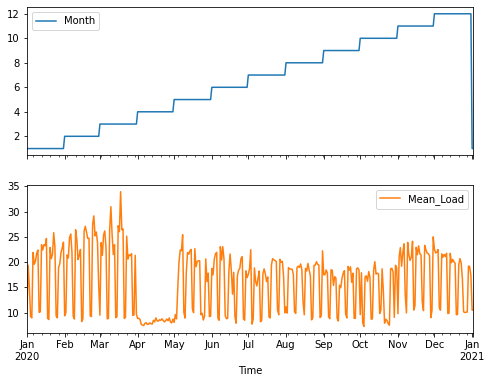

In [39]:
df.resample('D').mean().plot(subplots=True)  # try using the hourly data to generate this

In [40]:
df_daily = df.resample('D').mean()
df_daily = df_daily.loc['2020']

In [41]:
# !python -m pip install prophet
from prophet import Prophet


In [42]:
df_daily_final = df_daily.reset_index()[['Time','Mean_Load']].rename({'Time':'ds','Mean_Load':'y'}, axis='columns')

In [43]:
df_daily_final

,ds,y
0,2020-01-01,10.521647
1,2020-01-02,19.374741
2,2020-01-03,14.829345
3,2020-01-04,9.208829
4,2020-01-05,8.949641
...,...,...
361,2020-12-27,10.084160
362,2020-12-28,10.094070
363,2020-12-29,19.213499
364,2020-12-30,19.083969


In [44]:
train = df_daily_final[(df_daily_final['ds'] >= '2020-01-01') & (df_daily_final['ds']<='2020-09-30')]
test = df_daily_final[(df_daily_final['ds'] > '2020-09-30')]

In [45]:
train.shape, test.shape

((274, 2), (92, 2))

In [46]:
m = Prophet(interval_width=0.95, yearly_seasonality=True)

In [47]:
m.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb38f0i77/_c6ai6ml.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb38f0i77/f83r73h0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1541', 'data', 'file=/tmp/tmpb38f0i77/_c6ai6ml.json', 'init=/tmp/tmpb38f0i77/f83r73h0.json', 'output', 'file=/tmp/tmpb38f0i77/prophet_modelhcfhz5_9/prophet_model-20230316111957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:19:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:19:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [48]:
m.params

OrderedDict([('lp__', array([[529.759]])),
             ('k', array([[0.220108]])),
             ('m', array([[0.349717]])),
             ('delta',
              array([[ 2.66708e-09, -2.97284e-09, -1.18891e-09,  1.67156e-11,
                      -2.13777e-09, -3.12815e-09,  1.07448e-09,  8.02571e-10,
                      -5.57134e-10, -1.86794e-09, -2.12310e-09,  2.34996e-09,
                       3.80323e-09, -1.24166e-09, -3.26761e-09,  9.27934e-09,
                      -3.79322e-10,  4.94748e-09, -3.09742e-10,  1.91188e-09,
                       4.34345e-09, -8.34052e-09,  1.14380e-09,  4.86284e-10,
                       1.05878e-06]])),
             ('sigma_obs', array([[0.0884857]])),
             ('beta',
              array([[ 0.064191  ,  0.0657782 ,  0.0654595 ,  0.0198963 ,  0.0563045 ,
                      -0.0616978 , -0.00538643, -0.0458197 ,  0.00319086,  0.0353079 ,
                       0.0519677 ,  0.00076668,  0.0412688 , -0.0344427 ,  0.0170257 ,
           

In [49]:
future = m.make_future_dataframe(periods=92)
future.tail()

,ds
361,2020-12-27
362,2020-12-28
363,2020-12-29
364,2020-12-30
365,2020-12-31


In [50]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
361,2020-12-27,11.861798,5.852615,17.957862
362,2020-12-28,22.915773,16.827042,28.574498
363,2020-12-29,23.203374,17.188108,29.165526
364,2020-12-30,24.490562,18.066434,30.066687
365,2020-12-31,25.252081,19.887107,30.951710


In [51]:
df_daily_final

,ds,y
0,2020-01-01,10.521647
1,2020-01-02,19.374741
2,2020-01-03,14.829345
3,2020-01-04,9.208829
4,2020-01-05,8.949641
...,...,...
361,2020-12-27,10.084160
362,2020-12-28,10.094070
363,2020-12-29,19.213499
364,2020-12-30,19.083969


<AxesSubplot:xlabel='ds'>

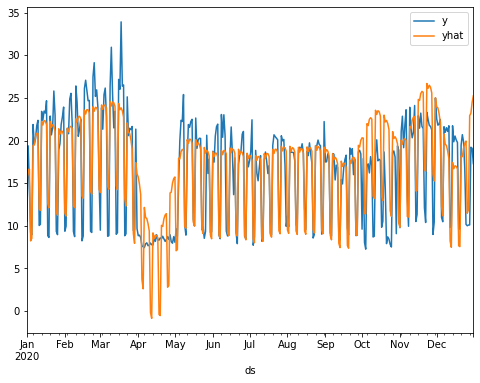

In [52]:
pd.concat([df_daily_final.set_index('ds')['y'], forecast.set_index('ds')['yhat']],axis=1).plot()

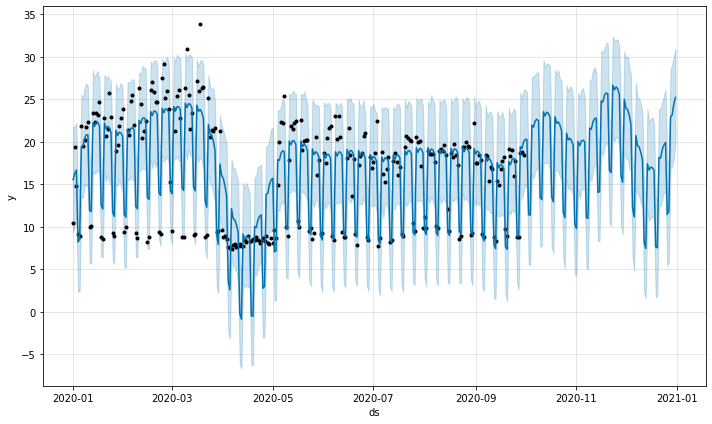

In [53]:
fig1 = m.plot(forecast)

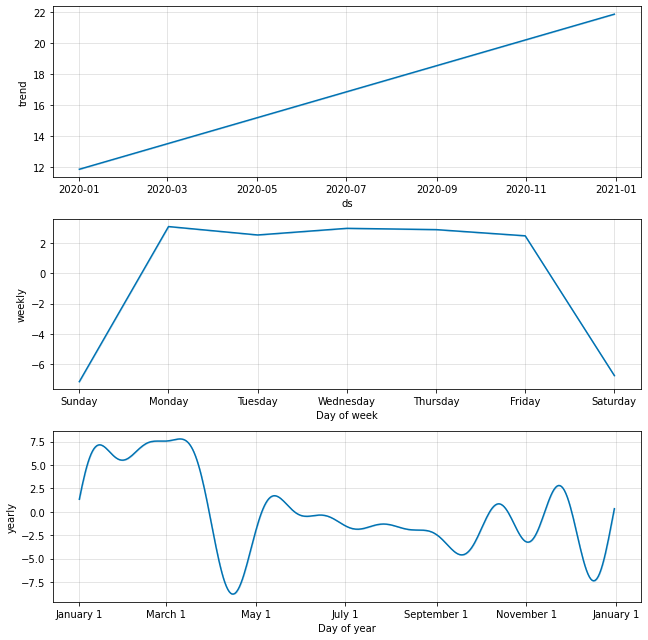

In [54]:
fig2 = m.plot_components(forecast)

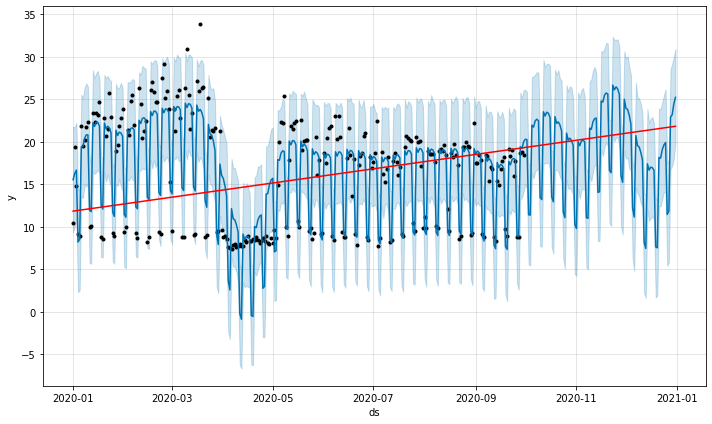

In [55]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [56]:
deltas = m.params['delta'].mean(0)
deltas

array([ 2.66708e-09, -2.97284e-09, -1.18891e-09,  1.67156e-11,
       -2.13777e-09, -3.12815e-09,  1.07448e-09,  8.02571e-10,
       -5.57134e-10, -1.86794e-09, -2.12310e-09,  2.34996e-09,
        3.80323e-09, -1.24166e-09, -3.26761e-09,  9.27934e-09,
       -3.79322e-10,  4.94748e-09, -3.09742e-10,  1.91188e-09,
        4.34345e-09, -8.34052e-09,  1.14380e-09,  4.86284e-10,
        1.05878e-06])

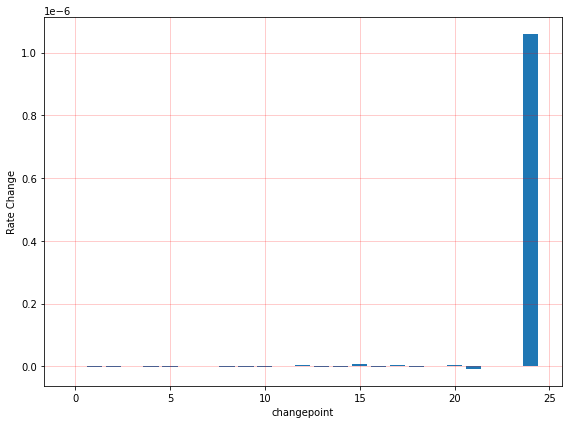

In [57]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)),deltas)
ax.grid(True, which='major', c='red', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate Change')
ax.set_xlabel('changepoint')
fig.tight_layout()

In [58]:
m.changepoints

9     2020-01-10
17    2020-01-18
26    2020-01-27
35    2020-02-05
44    2020-02-14
52    2020-02-22
61    2020-03-02
70    2020-03-11
78    2020-03-19
87    2020-03-28
96    2020-04-06
105   2020-04-15
113   2020-04-23
122   2020-05-02
131   2020-05-11
140   2020-05-20
148   2020-05-28
157   2020-06-06
166   2020-06-15
174   2020-06-23
183   2020-07-02
192   2020-07-11
201   2020-07-20
209   2020-07-28
218   2020-08-06
Name: ds, dtype: datetime64[ns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb38f0i77/o5l0j1xg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb38f0i77/jru1kzhv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10765', 'data', 'file=/tmp/tmpb38f0i77/o5l0j1xg.json', 'init=/tmp/tmpb38f0i77/jru1kzhv.json', 'output', 'file=/tmp/tmpb38f0i77/prophet_modelyumswxxd/prophet_model-20230316112000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:20:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


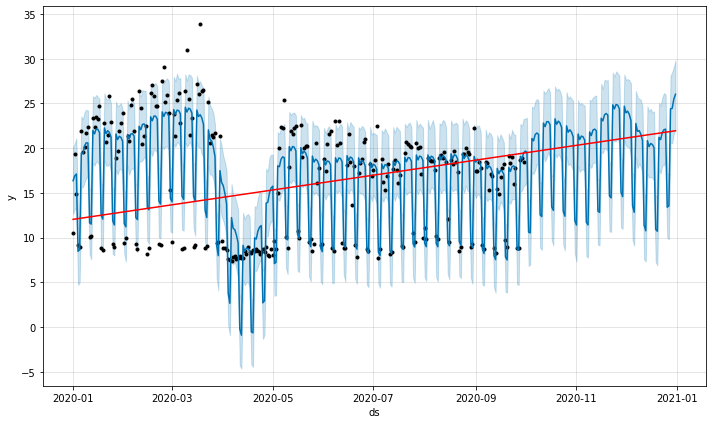

In [59]:
pro_change = Prophet(changepoint_range=0.9, yearly_seasonality=True)
forecast = pro_change.fit(train).predict(future)
fig = pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [60]:
# Python
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.offline as py


fig = plot_plotly(m, forecast)
py.iplot(fig)

In [61]:
from prophet.diagnostics import cross_validation
cv_results = cross_validation(model=m, initial = '152 days', horizon = '120 days')

INFO:prophet:Making 1 forecasts with cutoffs between 2020-06-02 00:00:00 and 2020-06-02 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb38f0i77/fojvmgs_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb38f0i77/acumlqq_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70018', 'data', 'file=/tmp/tmpb38f0i77/fojvmgs_.json', 'init=/tmp/tmpb38f0i77/acumlqq_.json', 'output', 'file=/tmp/tmpb38f0i77/prophet_model6utcyqeb/prophet_model-20230316112001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:20:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [62]:
cv_results.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-06-03,19.591253,13.224963,25.861532,20.506028,2020-06-02
1,2020-06-04,20.567650,13.810461,26.751267,21.623585,2020-06-02
2,2020-06-05,21.314180,14.690307,28.156089,21.921900,2020-06-02
3,2020-06-06,12.637563,5.888340,19.256500,8.898851,2020-06-02
4,2020-06-07,13.526595,6.627899,19.804336,8.478629,2020-06-02


In [63]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(cv_results)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,12 days,92.825335,9.634591,7.132623,0.656862,0.349899,0.395759,0.666667
1,13 days,118.890208,10.903679,8.532157,0.734763,0.441160,0.446745,0.583333
2,14 days,136.977851,11.703754,9.675035,0.787710,0.528781,0.485056,0.500000
3,15 days,169.718847,13.027619,11.276959,0.874877,0.639781,0.540934,0.416667
4,16 days,223.367125,14.945472,13.102632,0.996444,0.831805,0.592734,0.333333
...,...,...,...,...,...,...,...,...
104,116 days,89.968148,9.485154,8.554021,0.579890,0.521016,0.431086,0.416667
105,117 days,67.404184,8.210005,7.343032,0.506446,0.399935,0.388778,0.500000
106,118 days,50.024108,7.072772,6.324796,0.444598,0.337820,0.348337,0.583333
107,119 days,36.714147,6.059220,5.393107,0.391754,0.317366,0.310969,0.666667


In [64]:
df_acc_check = pd.concat([df_daily_final.set_index('ds')['y'], forecast.set_index('ds')['yhat']],axis=1).reset_index()

In [65]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(df_acc_check['y'], df_acc_check['yhat'])
mse = mean_squared_error(df_acc_check['y'], df_acc_check['yhat'])

mae, mse

(2.4309952709063, 12.504878414424773)

Holidays

In [72]:
holiday = {
    'holiday': ['Public_holidays', 'Public_holidays', 'Public_holidays', 'Public_holidays', 'Public_holidays', 'Public_holidays', 'Public_holidays', 'Public_holidays', 'Public_holidays', 'Public_holidays', 'Public_holidays', 'Public_holidays', 'Public_holidays', 'Public_holidays'],
    'ds': ['2020-01-01', '2020-04-10', '2020-04-13', '2020-05-01', '2020-05-25', '2020-05-26', '2020-06-12', '2020-07-30', '2020-07-31', '2020-10-01', '2020-10-29', '2020-12-25', '2020-12-28', '2020-12-31'],
    'lower_window': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'upper_window': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
}
holiday = pd.DataFrame(holiday)

In [73]:
holiday

,holiday,ds,lower_window,upper_window
0,Public_holidays,2020-01-01,0,1
1,Public_holidays,2020-04-10,0,1
2,Public_holidays,2020-04-13,0,1
3,Public_holidays,2020-05-01,0,1
4,Public_holidays,2020-05-25,0,1
5,Public_holidays,2020-05-26,0,1
6,Public_holidays,2020-06-12,0,1
7,Public_holidays,2020-07-30,0,1
8,Public_holidays,2020-07-31,0,1
9,Public_holidays,2020-10-01,0,1


In [75]:
m2 = Prophet(interval_width = 0.95, seasonality_mode='multiplicative', holidays = holiday)

In [76]:
m2.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb38f0i77/avyin568.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb38f0i77/t__pvbb7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63357', 'data', 'file=/tmp/tmpb38f0i77/avyin568.json', 'init=/tmp/tmpb38f0i77/t__pvbb7.json', 'output', 'file=/tmp/tmpb38f0i77/prophet_models9rwxzuk/prophet_model-20230316112521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:25:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:25:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [77]:
forecast = m2.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
361,2020-12-27,8.831499,1.470293,15.537864
362,2020-12-28,10.552080,3.146393,17.518570
363,2020-12-29,18.404660,10.691069,25.980063
364,2020-12-30,19.177791,11.797263,26.193138
365,2020-12-31,10.028102,2.494052,17.326598


<AxesSubplot:xlabel='ds'>

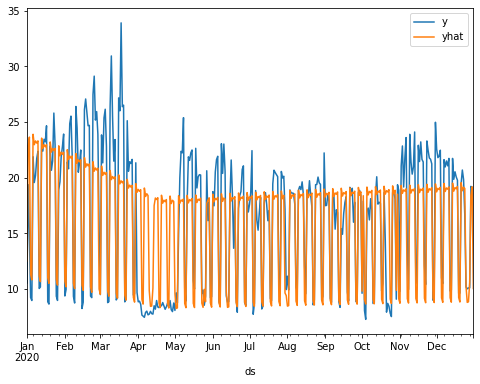

In [78]:
pd.concat([df_daily_final.set_index('ds')['y'], forecast.set_index('ds')['yhat']],axis=1).plot()

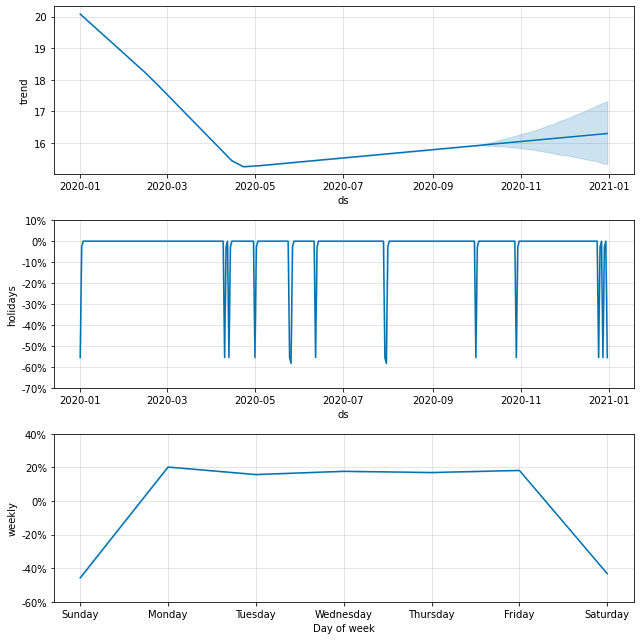

In [79]:
fig2 = m2.plot_components(forecast)